# Exploration des Données - Sentiment140

Ce notebook permet d'explorer le dataset Sentiment140 pour comprendre les caractéristiques des tweets et identifier les insights clés pour la modélisation.

## Objectifs
- Analyser la distribution des sentiments
- Examiner les caractéristiques textuelles
- Identifier les patterns de données
- Détecter les problèmes de qualité
- Définir la stratégie de preprocessing

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Bibliothèques importées avec succès")

Bibliothèques importées avec succès


## 1. Chargement des Données

In [2]:
# Chargement du dataset complet
data_path = '../data/training.1600000.processed.noemoticon.csv'
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Chargement d'un échantillon pour l'exploration rapide
print("Chargement des tweets...")
#df_sample = pd.read_csv(data_path, names=columns, encoding='latin1')
df_sample = pd.read_csv(data_path, names=columns, encoding='latin1')

print(f"nombre de lignes chargé chargé: {df_sample.shape[0]} tweets")
print(f"Colonnes ({df_sample.shape[1]}): {list(df_sample.columns)}")
df_sample.head()

Chargement des tweets...
nombre de lignes chargé chargé: 1600000 tweets
Colonnes (6): ['sentiment', 'id', 'date', 'query', 'user', 'text']


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Informations générales
print("=== INFORMATIONS GÉNÉRALES ===")
print(f"Nombre total de tweets: {len(df_sample)}")
print(f"Période temporelle: {df_sample['date'].min()} à {df_sample['date'].max()}")
print(f"Nombre d'utilisateurs uniques: {df_sample['user'].nunique()}")
print(f"Valeurs manquantes par colonne:")
print(df_sample.isnull().sum())
for col in ["sentiment", "query"]:
    # valeurs uniques pour la colonne sentiment
    print(f"Valeurs uniques par colonne \"{col}\" ({df_sample[col].nunique()}): {df_sample[col].unique()}")

=== INFORMATIONS GÉNÉRALES ===
Nombre total de tweets: 1600000
Période temporelle: Fri Apr 17 20:30:31 PDT 2009 à Wed May 27 07:27:38 PDT 2009
Nombre d'utilisateurs uniques: 659775
Valeurs manquantes par colonne:
sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64
Valeurs uniques par colonne "sentiment" (2): [0 4]
Valeurs uniques par colonne "query" (1): ['NO_QUERY']


## 2. Distribution des Sentiments

In [4]:
# Conversion des labels (0=négatif, 4=positif) vers (0=négatif, 1=positif)
df_sample['sentiment_binary'] = df_sample['sentiment'].map({0: 0, 4: 1})

Valeurs uniques par colonne "sentiment" (2): [0 4]
=== DISTRIBUTION DES SENTIMENTS ===
Négatif (0): 800000 tweets (50.0%)
Positif (1): 800000 tweets (50.0%)


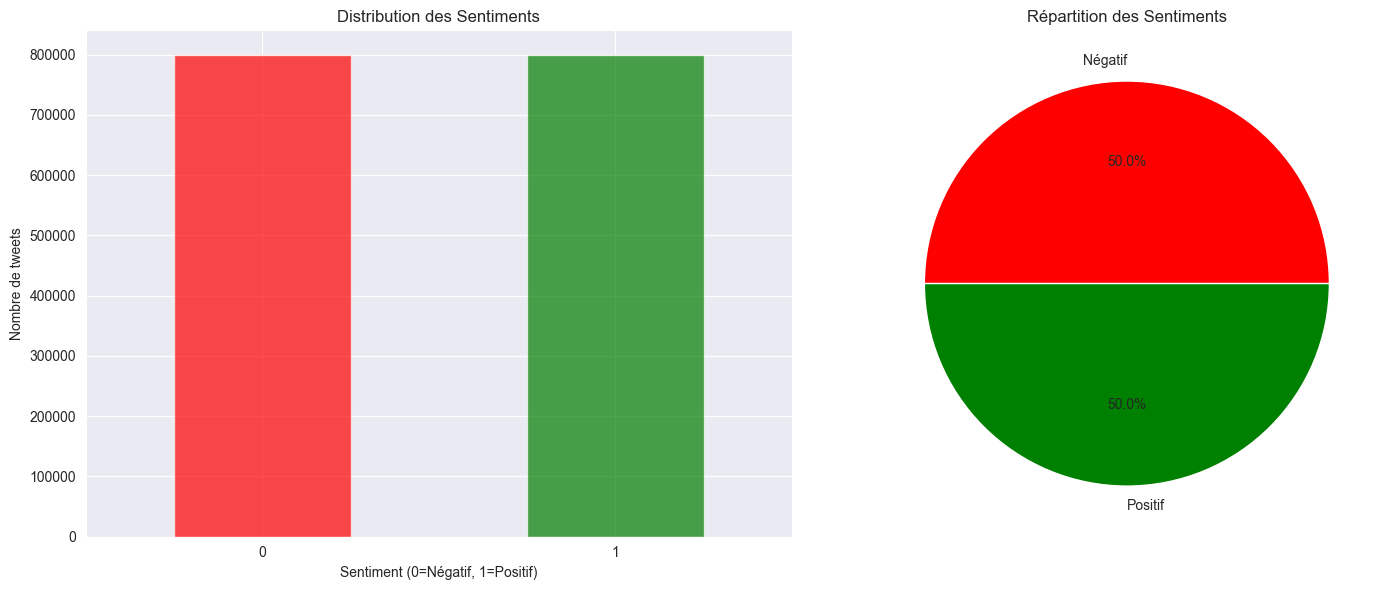

In [5]:
# valeurs uniques pour la colonne sentiment
print(f"Valeurs uniques par colonne \"sentiment\" ({df_sample['sentiment'].nunique()}): {df_sample['sentiment'].unique()}")
# Distribution des sentiments
sentiment_counts = df_sample['sentiment_binary'].value_counts().sort_index()
print("=== DISTRIBUTION DES SENTIMENTS ===")
print(f"Négatif (0): {sentiment_counts[0]} tweets ({sentiment_counts[0]/len(df_sample)*100:.1f}%)")
print(f"Positif (1): {sentiment_counts[1]} tweets ({sentiment_counts[1]/len(df_sample)*100:.1f}%)")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique en barres
sentiment_counts.plot(kind='bar', ax=ax1, color=['red', 'green'], alpha=0.7)
ax1.set_title('Distribution des Sentiments')
ax1.set_xlabel('Sentiment (0=Négatif, 1=Positif)')
ax1.set_ylabel('Nombre de tweets')
ax1.tick_params(axis='x', rotation=0)

# Graphique circulaire
sentiment_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                     labels=['Négatif', 'Positif'], colors=['red', 'green'])
ax2.set_title('Répartition des Sentiments')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Analyse Textuelle

In [6]:
# Statistiques textuelles
df_sample['text_length'] = df_sample['text'].str.len()
df_sample['word_count'] = df_sample['text'].str.split().str.len()

print("=== STATISTIQUES TEXTUELLES ===")
print(f"Longueur moyenne des tweets: {df_sample['text_length'].mean():.1f} caractères")
print(f"Nombre moyen de mots: {df_sample['word_count'].mean():.1f} mots")
print(f"Tweet le plus court: {df_sample['text_length'].min()} caractères")
print(f"Tweet le plus long: {df_sample['text_length'].max()} caractères")

# Distribution par sentiment
print("\n=== STATISTIQUES PAR SENTIMENT ===")
stats_by_sentiment = df_sample.groupby('sentiment_binary')[['text_length', 'word_count']].agg(['mean', 'std'])
print(stats_by_sentiment)

=== STATISTIQUES TEXTUELLES ===
Longueur moyenne des tweets: 74.1 caractères
Nombre moyen de mots: 13.2 mots
Tweet le plus court: 6 caractères
Tweet le plus long: 374 caractères

=== STATISTIQUES PAR SENTIMENT ===
                 text_length            word_count          
                        mean        std       mean       std
sentiment_binary                                            
0                  74.301790  36.743260  13.581984  7.073519
1                  73.878433  36.135274  12.770318  6.816371


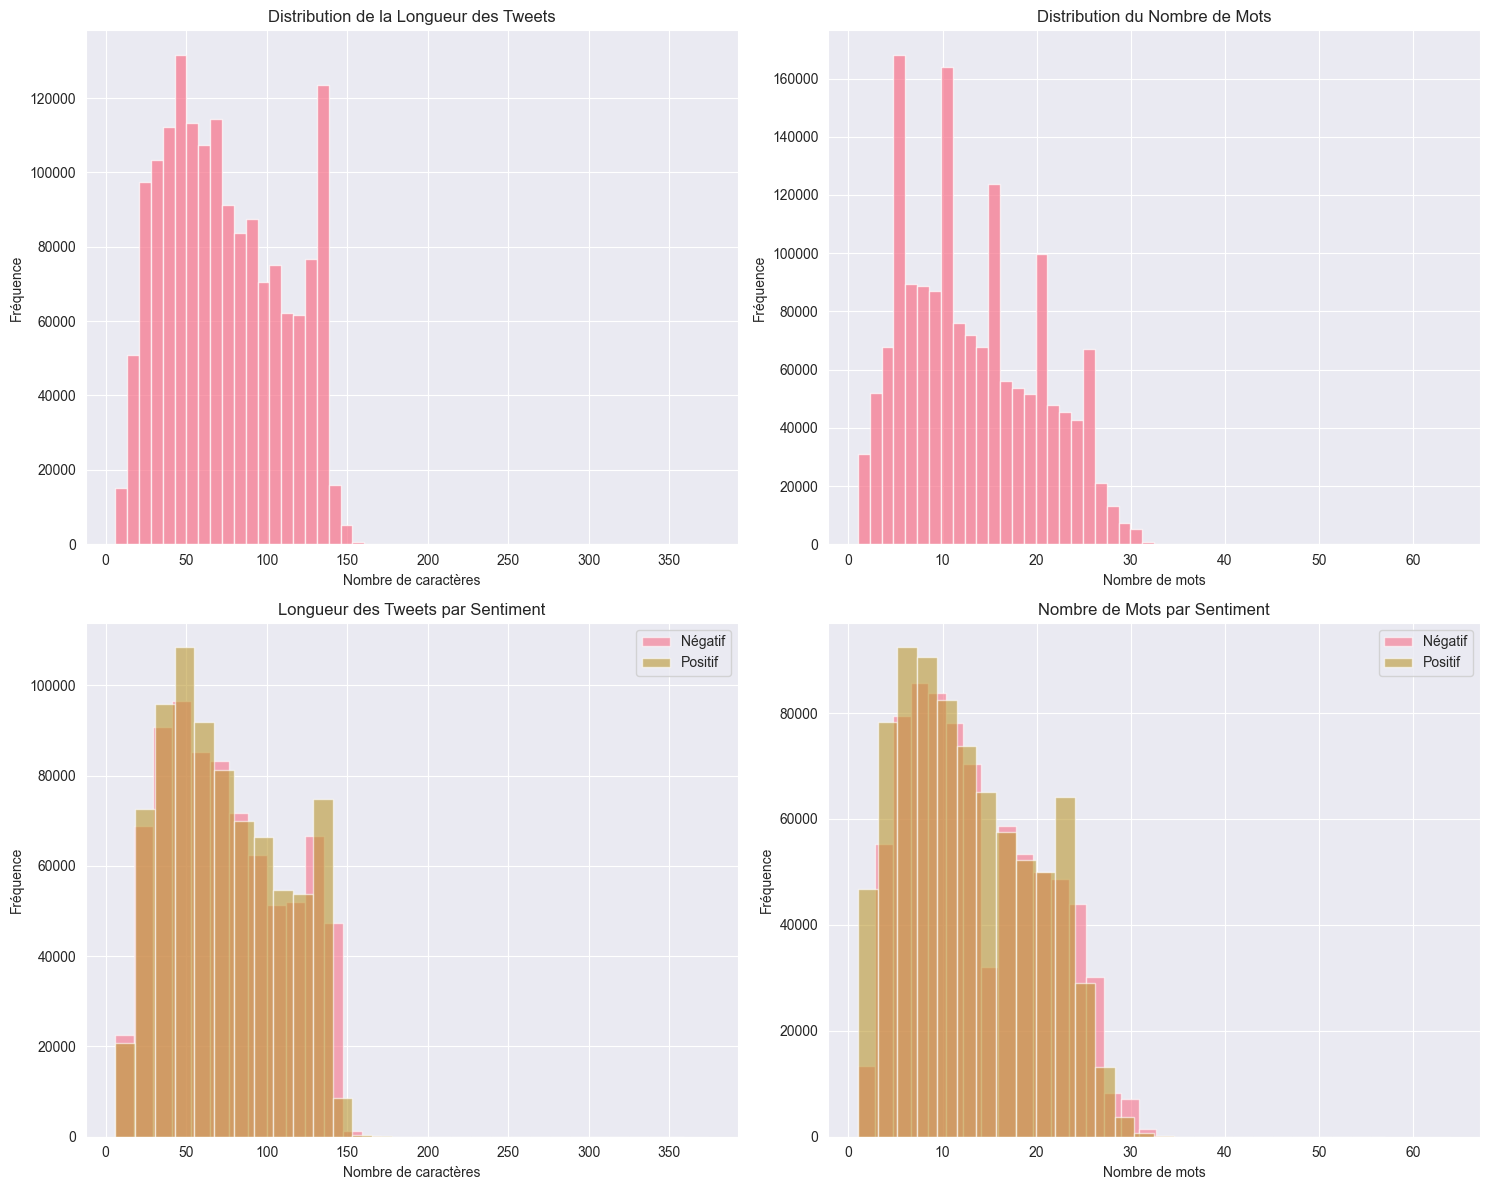

In [7]:
# Visualisation des distributions textuelles
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution de la longueur des tweets
df_sample['text_length'].hist(bins=50, alpha=0.7, ax=axes[0,0])
axes[0,0].set_title('Distribution de la Longueur des Tweets')
axes[0,0].set_xlabel('Nombre de caractères')
axes[0,0].set_ylabel('Fréquence')

# Distribution du nombre de mots
df_sample['word_count'].hist(bins=50, alpha=0.7, ax=axes[0,1])
axes[0,1].set_title('Distribution du Nombre de Mots')
axes[0,1].set_xlabel('Nombre de mots')
axes[0,1].set_ylabel('Fréquence')

# Longueur par sentiment
for sentiment in [0, 1]:
    subset = df_sample[df_sample['sentiment_binary'] == sentiment]
    label = 'Négatif' if sentiment == 0 else 'Positif'
    axes[1,0].hist(subset['text_length'], bins=30, alpha=0.6, label=label)
axes[1,0].set_title('Longueur des Tweets par Sentiment')
axes[1,0].set_xlabel('Nombre de caractères')
axes[1,0].set_ylabel('Fréquence')
axes[1,0].legend()

# Mots par sentiment
for sentiment in [0, 1]:
    subset = df_sample[df_sample['sentiment_binary'] == sentiment]
    label = 'Négatif' if sentiment == 0 else 'Positif'
    axes[1,1].hist(subset['word_count'], bins=30, alpha=0.6, label=label)
axes[1,1].set_title('Nombre de Mots par Sentiment')
axes[1,1].set_xlabel('Nombre de mots')
axes[1,1].set_ylabel('Fréquence')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Analyse des Patterns Textuels

=== PATTERNS TEXTUELS ===
Urls: 81117 tweets (5.1%)
Mentions: 738493 tweets (46.2%)


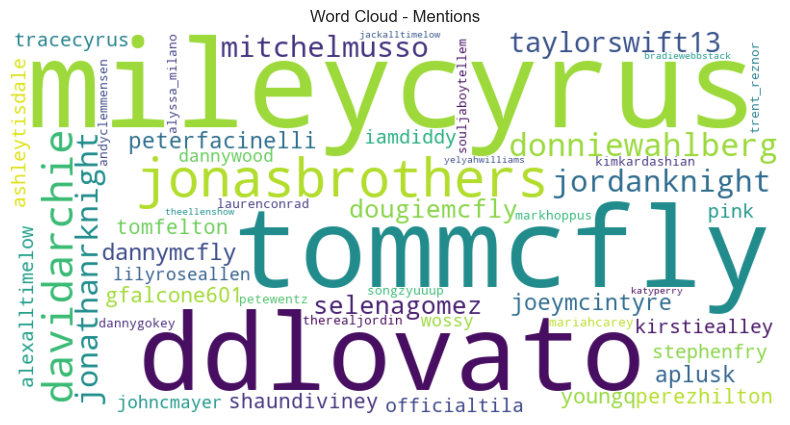

[('mileycyrus', 4580), ('tommcfly', 3904), ('ddlovato', 3474), ('jonasbrothers', 2384), ('davidarchie', 1386), ('donniewahlberg', 1330), ('jonathanrknight', 1266), ('jordanknight', 1150), ('mitchelmusso', 1103), ('taylorswift13', 1026), ('selenagomez', 805), ('dougiemcfly', 802), ('dannymcfly', 703), ('peterfacinelli', 644), ('aplusk', 625), ('joeymcintyre', 611), ('youngq', 562), ('gfalcone601', 540), ('shaundiviney', 513), ('perezhilton', 504), ('tomfelton', 484), ('officialtila', 451), ('kirstiealley', 439), ('alexalltimelow', 428), ('stephenfry', 423), ('pink', 417), ('tracecyrus', 406), ('iamdiddy', 399), ('ashleytisdale', 391), ('lilyroseallen', 388), ('wossy', 385), ('johncmayer', 383), ('dannywood', 381), ('therealjordin', 359), ('kimkardashian', 356), ('songzyuuup', 355), ('souljaboytellem', 348), ('laurenconrad', 346), ('andyclemmensen', 343), ('dannygokey', 343), ('markhoppus', 342), ('petewentz', 337), ('alyssa_milano', 320), ('mariahcarey', 320), ('trent_reznor', 316), ('y

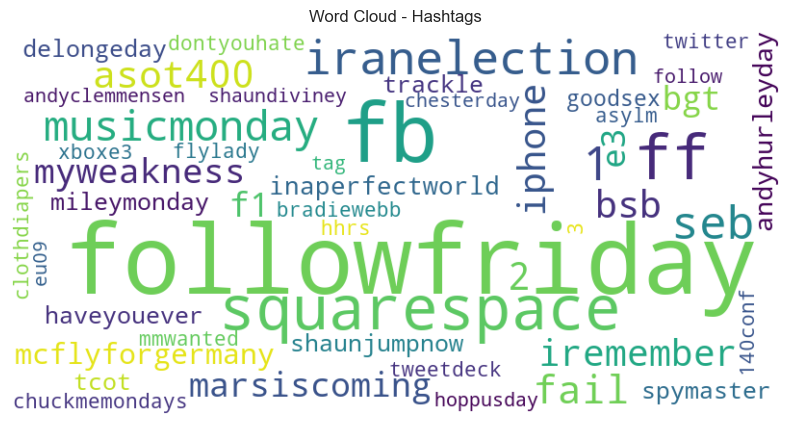

[('followfriday', 2640), ('fb', 1786), ('ff', 985), ('squarespace', 941), ('1', 519), ('iranelection', 518), ('seb', 499), ('musicmonday', 422), ('fail', 363), ('2', 341), ('asot400', 333), ('iphone', 318), ('bsb', 314), ('iremember', 299), ('myweakness', 272), ('marsiscoming', 260), ('f1', 258), ('e3', 257), ('bgt', 246), ('mcflyforgermany', 230), ('andyhurleyday', 188), ('inaperfectworld', 185), ('haveyouever', 174), ('spymaster', 170), ('delongeday', 167), ('trackle', 162), ('tcot', 161), ('shaunjumpnow', 161), ('mileymonday', 160), ('goodsex', 132), ('3', 126), ('twitter', 115), ('chuckmemondays', 112), ('xboxe3', 107), ('hhrs', 106), ('bradiewebb', 106), ('clothdiapers', 105), ('dontyouhate', 105), ('mmwanted', 103), ('140conf', 102), ('tweetdeck', 98), ('asylm', 98), ('flylady', 97), ('andyclemmensen', 95), ('chesterday', 95), ('tag', 93), ('shaundiviney', 93), ('follow', 93), ('eu09', 92), ('hoppusday', 91)]
Emojis: 0 tweets (0.0%)
Numbers: 366487 tweets (22.9%)
Uppercase: 12213

In [22]:
# Fonction pour extraire les patterns
def analyze_text_patterns(texts):
    def count_and_extract_patterns(regex, cleaned_symbol=None):
        pattern_texts = [text for text in texts if re.search(regex, str(text))]
        pattern_words = []
        for text in pattern_texts:
            pattern_words.extend(re.findall(regex, str(text)))

        word_list = [word.lower().strip() for word in pattern_words]
        if cleaned_symbol:
            word_list = [word.replace(cleaned_symbol, "") for word in word_list]

        return len(pattern_texts), word_list

    patterns = {
        'urls': count_and_extract_patterns(r'http\S+|www\S+'),
        'mentions': count_and_extract_patterns(r'@\w+', cleaned_symbol="@"),
        'hashtags': count_and_extract_patterns(r'#\w+', cleaned_symbol="#"),
        'emojis': count_and_extract_patterns(r'[😀-🙏]'),
        'numbers': count_and_extract_patterns(r'\d+'),
        'uppercase': count_and_extract_patterns(r'[A-Z]'),
        'punctuation': count_and_extract_patterns(r'[!?]{2,}')
    }
    return patterns

# Analyse globale
all_patterns = analyze_text_patterns(df_sample['text'])
total_tweets = len(df_sample)

print("=== PATTERNS TEXTUELS ===")
for pattern, (count, text_list) in all_patterns.items():
    percentage = (count / total_tweets) * 100
    print(f"{pattern.capitalize()}: {count} tweets ({percentage:.1f}%)")

    if count > 0 and pattern in ['mentions', 'hashtags', 'emojis']:
        hashtag_freq_top_50 = Counter(text_list).most_common(50)


        # Visualisation préliminaire : nuage de mots pour identifier les termes dominants
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
        ).generate_from_frequencies(dict(hashtag_freq_top_50))

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud - {pattern.capitalize()}")
        plt.show()
        print(hashtag_freq_top_50)




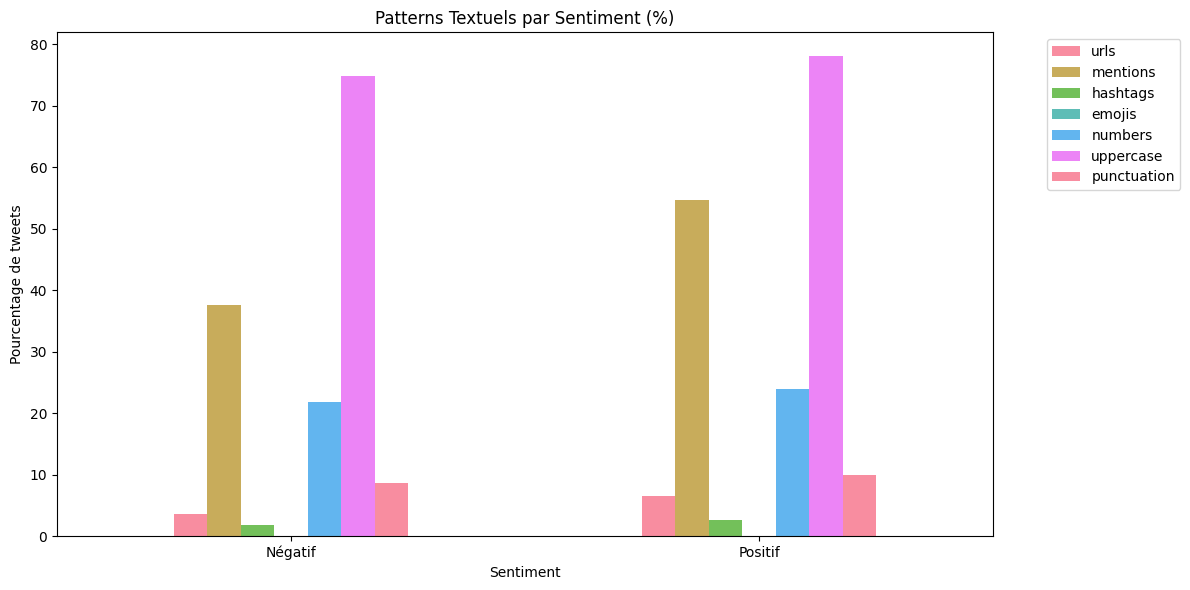


=== PATTERNS PAR SENTIMENT (%) ===
         urls  mentions  hashtags  emojis  numbers  uppercase  punctuation
Négatif   3.5      37.6       1.9       0     21.9       74.8          8.7
Positif   6.6      54.7       2.6       0     23.9       78.0          9.9


In [12]:
# Analyse par sentiment
patterns_by_sentiment = {}
for sentiment in [0, 1]:
    subset = df_sample[df_sample['sentiment_binary'] == sentiment]
    patterns_by_sentiment[sentiment] = analyze_text_patterns(subset['text'])

# Visualisation des patterns par sentiment
patterns_df = pd.DataFrame(patterns_by_sentiment).T
patterns_df.index = ['Négatif', 'Positif']

# Conversion en pourcentages
for sentiment in [0, 1]:
    total = sentiment_counts[sentiment]
    for pattern in patterns_df.columns:
        patterns_df.loc['Négatif' if sentiment == 0 else 'Positif', pattern] = \
            (patterns_df.loc['Négatif' if sentiment == 0 else 'Positif', pattern] / total) * 100

# Graphique
ax = patterns_df.plot(kind='bar', figsize=(12, 6), alpha=0.8)
ax.set_title('Patterns Textuels par Sentiment (%)')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Pourcentage de tweets')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n=== PATTERNS PAR SENTIMENT (%) ===")
print(patterns_df.round(1))

## 5. Analyse des Utilisateurs

=== STATISTIQUES UTILISATEURS ===
Nombre d'utilisateurs uniques: 659775
Nombre moyen de tweets par utilisateur: 2.4
Utilisateur le plus actif: 549 tweets


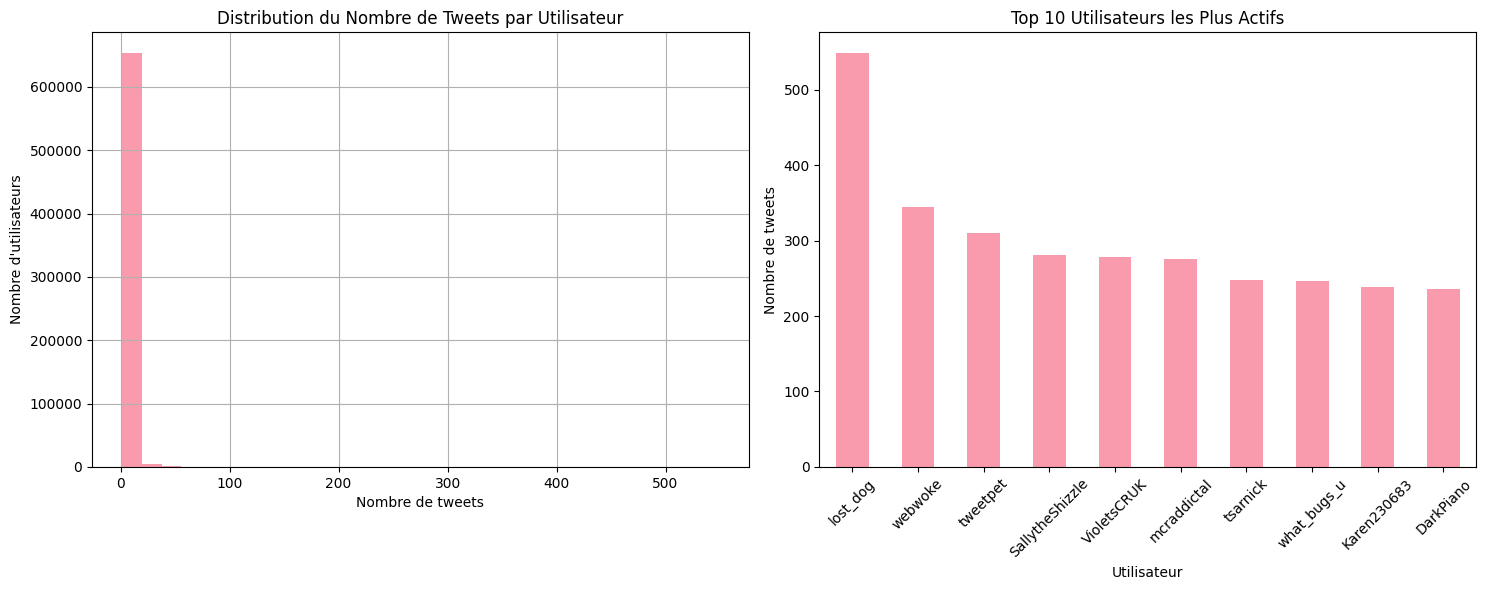

In [13]:
# Analyse des utilisateurs
user_stats = df_sample.groupby('user').agg({
    'sentiment_binary': ['count', 'mean'],
    'text_length': 'mean'
}).round(2)

user_stats.columns = ['nb_tweets', 'sentiment_moyen', 'longueur_moyenne']

print("=== STATISTIQUES UTILISATEURS ===")
print(f"Nombre d'utilisateurs uniques: {len(user_stats)}")
print(f"Nombre moyen de tweets par utilisateur: {user_stats['nb_tweets'].mean():.1f}")
print(f"Utilisateur le plus actif: {user_stats['nb_tweets'].max()} tweets")

# Distribution du nombre de tweets par utilisateur
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

user_stats['nb_tweets'].hist(bins=30, ax=ax1, alpha=0.7)
ax1.set_title('Distribution du Nombre de Tweets par Utilisateur')
ax1.set_xlabel('Nombre de tweets')
ax1.set_ylabel('Nombre d\'utilisateurs')

# Top 10 des utilisateurs les plus actifs
top_users = user_stats.nlargest(10, 'nb_tweets')
top_users['nb_tweets'].plot(kind='bar', ax=ax2, alpha=0.7)
ax2.set_title('Top 10 Utilisateurs les Plus Actifs')
ax2.set_xlabel('Utilisateur')
ax2.set_ylabel('Nombre de tweets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 6. Analyse Temporelle

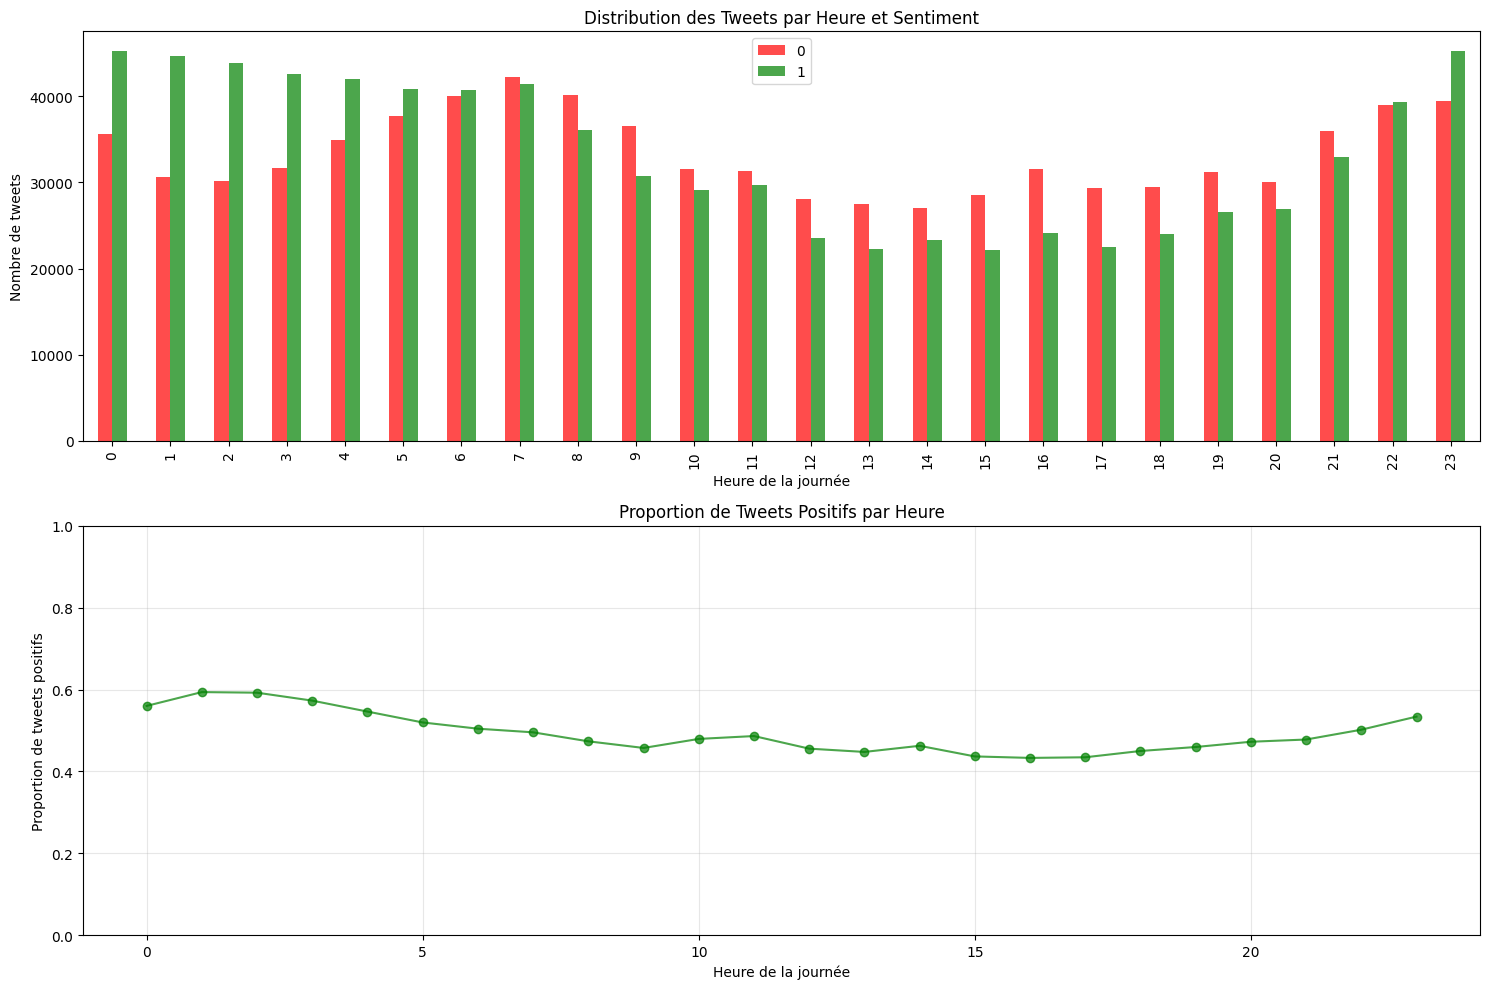

=== STATISTIQUES TEMPORELLES ===
Période couverte: 2009-04-06 22:19:45 à 2009-06-25 10:28:31
Heure la plus active: 23h
Heure la moins active: 13h


In [14]:
# Conversion de la date
df_sample['date_parsed'] = pd.to_datetime(df_sample['date'], errors='coerce')
df_sample['hour'] = df_sample['date_parsed'].dt.hour
df_sample['day_of_week'] = df_sample['date_parsed'].dt.day_name()

# Analyse par heure
hourly_stats = df_sample.groupby(['hour', 'sentiment_binary']).size().unstack(fill_value=0)

# Visualisation temporelle
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Distribution par heure
hourly_stats.plot(kind='bar', ax=ax1, alpha=0.7, 
                 color=['red', 'green'], label=['Négatif', 'Positif'])
ax1.set_title('Distribution des Tweets par Heure et Sentiment')
ax1.set_xlabel('Heure de la journée')
ax1.set_ylabel('Nombre de tweets')
ax1.legend()

# Proportion de sentiment positif par heure
hourly_proportion = hourly_stats.div(hourly_stats.sum(axis=1), axis=0)
hourly_proportion[1].plot(kind='line', ax=ax2, marker='o', color='green', alpha=0.7)
ax2.set_title('Proportion de Tweets Positifs par Heure')
ax2.set_xlabel('Heure de la journée')
ax2.set_ylabel('Proportion de tweets positifs')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== STATISTIQUES TEMPORELLES ===")
print(f"Période couverte: {df_sample['date_parsed'].min()} à {df_sample['date_parsed'].max()}")
print(f"Heure la plus active: {hourly_stats.sum(axis=1).idxmax()}h")
print(f"Heure la moins active: {hourly_stats.sum(axis=1).idxmin()}h")

## 7. Exemples de Tweets par Sentiment

In [15]:
# Exemples de tweets négatifs
print("=== EXEMPLES DE TWEETS NÉGATIFS ===")
negative_tweets = df_sample[df_sample['sentiment_binary'] == 0]['text'].sample(5, random_state=42)
for i, tweet in enumerate(negative_tweets, 1):
    print(f"{i}. {tweet}")

print("\n=== EXEMPLES DE TWEETS POSITIFS ===")
positive_tweets = df_sample[df_sample['sentiment_binary'] == 1]['text'].sample(5, random_state=42)
for i, tweet in enumerate(positive_tweets, 1):
    print(f"{i}. {tweet}")

=== EXEMPLES DE TWEETS NÉGATIFS ===
1. @xnausikaax oh no! where did u order from? that's horrible 
2. A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now 
3. Right, off to work  Only 5 hours to go until I'm free xD
4. I am craving for japanese food 
5. Jean Michel Jarre concert tomorrow  gotta work 7-3 before though 

=== EXEMPLES DE TWEETS POSITIFS ===
1. Is lookin 4ward to a long weekend  really dont want to go to work 2day tho =[ x
2. #myweakness  Is music and i live to meet the people who make it 
3. figured out the Internet on my new iPod 
4. @hillsongunited can't wait to worship with you guys tonight. it'll be so much fun 
5. @sillybeggar Congrats James !! I'm sure the book is going to be a huge success 


## 8. Insights et Recommandations

In [16]:
print("=== INSIGHTS CLÉS ===")
print("\n1. DISTRIBUTION DES DONNÉES:")
print(f"   - Dataset équilibré: {sentiment_counts[0]} négatifs vs {sentiment_counts[1]} positifs")
print(f"   - Pas de déséquilibre majeur des classes")

print("\n2. CARACTÉRISTIQUES TEXTUELLES:")
print(f"   - Longueur moyenne: {df_sample['text_length'].mean():.0f} caractères")
print(f"   - Nombre moyen de mots: {df_sample['word_count'].mean():.1f}")

print("\n3. PATTERNS IMPORTANTS:")
url_pct = (all_patterns['urls'][0] / total_tweets) * 100
mention_pct = (all_patterns['mentions'][0] / total_tweets) * 100
hashtag_pct = (all_patterns['hashtags'][0] / total_tweets) * 100
print(f"   - URLs présentes dans {url_pct:.1f}% des tweets")
print(f"   - Mentions dans {mention_pct:.1f}% des tweets")
print(f"   - Hashtags dans {hashtag_pct:.1f}% des tweets")

print("\n=== RECOMMANDATIONS PREPROCESSING ===")
print("1. Supprimer les URLs (peu d'information sémantique)")
print("2. Traiter les mentions (@username) selon le contexte")
print("3. Conserver les hashtags (information sémantique)")
print("4. Normaliser la casse et la ponctuation")
print("5. Gérer les caractères spéciaux et emojis")

print("\n=== STRATÉGIE MODÉLISATION ===")
print("1. Utiliser la totalité du dataset (1.6M tweets)")
print("2. Split train/validation/test: 70/15/15")
print("3. Stratifier par sentiment pour maintenir l'équilibre")
print("4. Considérer la validation croisée pour robustesse")

=== INSIGHTS CLÉS ===

1. DISTRIBUTION DES DONNÉES:
   - Dataset équilibré: 800000 négatifs vs 800000 positifs
   - Pas de déséquilibre majeur des classes

2. CARACTÉRISTIQUES TEXTUELLES:
   - Longueur moyenne: 74 caractères
   - Nombre moyen de mots: 13.2
   - Tweets courts adaptés aux modèles de NLP

3. PATTERNS IMPORTANTS:
   - URLs présentes dans 5.1% des tweets
   - Mentions dans 46.2% des tweets
   - Hashtags dans 2.2% des tweets

=== RECOMMANDATIONS PREPROCESSING ===
1. Supprimer les URLs (peu d'information sémantique)
2. Traiter les mentions (@username) selon le contexte
3. Conserver les hashtags (information sémantique)
4. Normaliser la casse et la ponctuation
5. Gérer les caractères spéciaux et emojis

=== STRATÉGIE MODÉLISATION ===
1. Utiliser la totalité du dataset (1.6M tweets)
2. Split train/validation/test: 70/15/15
3. Stratifier par sentiment pour maintenir l'équilibre
4. Considérer la validation croisée pour robustesse
